## Table of contents
### - [Introduction](#Introduction)
### - [Setup](#Setup)
### - [Example image](#Example-image)
### - [Automatic mask generation](#Automatic-mask-generation)
### - [Automatic mask generation options](#Automatic-mask-generation-options)
### - [Classification model](#Classification-model)
### - [Inference](#Inference)
### - [Gradio app](#Gradio-app)
### - [Evaluation and conclusion](#Evaluation-and-conclusion)
### - [References](#References)

## Introduction

- In this notebook, I will combine Meta's segmentation model called **SAM** (Segment Anything Model)

    with a **pretrained image classification model** from the Timm library to create a simple Gradio 

    app. This app will categorize the objects found in an input image.

- A significant portion of the code and explanations presented here has been replicated and adapted

    from the sources detailed in the [References](#References) section.

- The purpose of this modest project is solely to experiment, learn, and practice.

    You can execute the cell containing the **Gradio app** independently.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
if not torch.cuda.is_available():
    print("Warning: CUDA support is strongly recommended for optimal runtime performance.")
    print("To proceed without CUDA, you can comment out the lines containing 'device' keyword.")
    print("See link below")
    print("Note: The Gradio app cell requires CUDA and will not function without it.")
    raise Exception("Please read the instructions above for proper configuration.")
import torchvision.transforms as transforms
import warnings
warnings.simplefilter('ignore')

!mkdir -p images sam_model
!wget -qq -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
try:
    !pip install -qq 'git+https://github.com/facebookresearch/segment-anything.git'
    !wget -qq -P sam_model https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
except Exception as e:
    print('Error message: ', e)
    print('Consider downloading the SAM model from:')
    print('https://github.com/facebookresearch/segment-anything#model-checkpoints')

##### - [Cell to modify if CUDA not available](#Cell-to-modify-if-CUDA-not-available)

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/working/images'):
    for filename in filenames:
        image_path = os.path.join(dirname, filename)
        
for dirname, _, filenames in os.walk('/kaggle/working/sam_model'):
    for filename in filenames:
        sam_model_path = os.path.join(dirname, filename)

In [3]:
image_path

'/kaggle/working/images/dog.jpg'

In [4]:
sam_model_path

'/kaggle/working/sam_model/sam_vit_b_01ec64.pth'

In [5]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

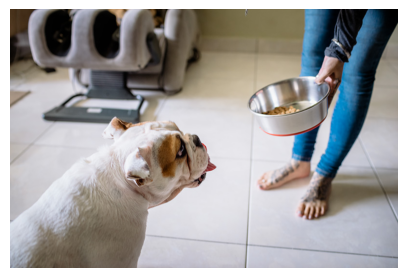

In [6]:
from PIL import Image
image = Image.open(image_path)
image = np.array(image.convert("RGB"))
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. 

Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

##### Cell to modify if CUDA not available

In [7]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = sam_model_path
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device);

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [8]:
masks = mask_generator.generate(image)

In [9]:
len(masks)

44

Show all the masks overlayed on the image

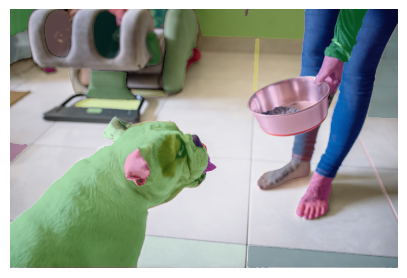

In [10]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how 

densely points are sampled and what the thresholds are for removing low quality or 

duplicate masks. Additionally, generation can be automatically run on crops of the 

image to get improved performance on smaller objects, and post-processing can remove 

stray pixels and holes. Here is an example configuration that samples more masks:

In [11]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [12]:
masks2 = mask_generator_2.generate(image)

In [13]:
len(masks2)

63

In [14]:
masks2[0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

Show all the masks overlayed on the image

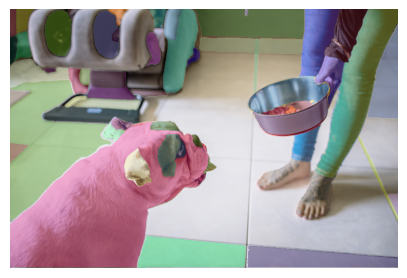

In [15]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

Show the dog mask in isolation, with dark background

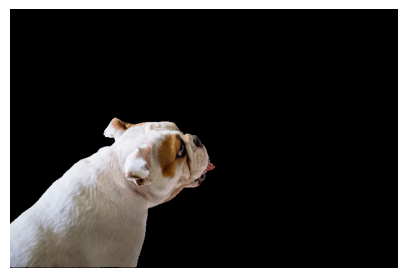

In [16]:
mask = masks2[23]['segmentation'].astype(np.uint8)
new_image = image * np.expand_dims(mask, axis=-1)
plt.figure(figsize=(5,5))
plt.imshow(new_image)
plt.axis('off')
plt.show()

Show each mask separately

In [17]:
# for i in range(len(masks2)):
#     print(i)
#     mask = masks[i]['segmentation'].astype(np.uint8)
#     new_image = image * np.expand_dims(mask, axis=-1)
#     plt.figure(figsize=(5,5))
#     plt.imshow(new_image)
#     plt.axis('off')
#     plt.show()

Function to determine whether a mask belongs to a greater one

In [18]:
def is_part_of(mask1, mask2):
    mask1, mask2 = mask1.flatten(), mask2.flatten()
    # True if mask1 is entirely contained within mask2
    if np.any(mask1 & ~mask2):
        return False
    # True if both masks are NOT identical    
    if np.count_nonzero(mask1)==np.count_nonzero(mask2):
        return False
    return True


# Check objects belonging to mask23

for i in range(len(masks2)):
    if is_part_of(masks2[i]['segmentation'], masks2[23]['segmentation']):
        print(f"Mask {i} is part of mask23")


# Check if mask21 belongs to another mask

for i in range(len(masks2)):
    if is_part_of(masks2[21]['segmentation'], masks2[i]['segmentation']):
        print(f"Mask 21 is part of mask {i}.")

Mask 21 is part of mask23
Mask 25 is part of mask23
Mask 49 is part of mask23
Mask 21 is part of mask 23.


## Classification model

In [19]:
import timm

# To list models with a specific pattern in their name
# timm.list_models('*huge*in1k*', pretrained=True)

cv_model = timm.create_model('convnext_small.in12k_ft_in1k_384', pretrained=True).eval()
try:
    data_cfg = timm.data.resolve_data_config(cv_model.pretrained_cfg)
    transform = timm.data.create_transform(**data_cfg)
except:
    transform = transforms.Compose([
        transforms.Resize(size=(384, 384), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(size=(384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

Chose the model `convnext_small.in12k_ft_in1k_384` because it delivers nearly 

state-of-the-art accuracy while requiring a reasonable amount of time for both download and inference. 

Find model comparison here: https://huggingface.co/timm/convnext_small.in12k_ft_in1k_384

Apply transform to image prior to inference

In [20]:
pil_image = Image.fromarray(new_image.astype(np.uint8))
image_tensor = transform(pil_image)

Show transformed image

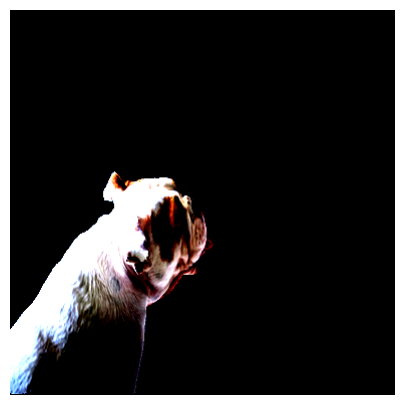

In [21]:
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(image_tensor, (1,2,0)))
plt.axis('off')
plt.show()

## Inference

In [22]:
with torch.no_grad():
    output = cv_model(image_tensor.unsqueeze(0))
output.shape

torch.Size([1, 1000])

In [23]:
probabilities = torch.nn.functional.softmax(output[0], dim=0)
probabilities.shape

torch.Size([1000])

In [24]:
# Keep 3 guesses with highest probability of success
values, indices = torch.topk(probabilities, 3)
indices

tensor([242, 179, 245])

Obtain labels from the `IMAGENET_1k` dataset

In [25]:
import requests
IMAGENET_1k_URL = 'https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt'
IMAGENET_1k_LABELS = requests.get(IMAGENET_1k_URL).text.strip().split('\n')
print('The 3 most likely labels for the given picture are:', '\n')
[{'label': IMAGENET_1k_LABELS[idx], 'value': np.round(value.item()*100, 2)} for value, idx in zip(values, indices)]

The 3 most likely labels for the given picture are: 



[{'label': 'boxer', 'value': 25.06},
 {'label': 'Staffordshire_bullterrier, Staffordshire_bull_terrier',
  'value': 21.74},
 {'label': 'French_bulldog', 'value': 11.69}]

----------------------

## Gradio app

The following cell contains the majority of the code seen in the previous sections and can be executed independently.

In [26]:
# Setup
try:
    !pip install -qq 'git+https://github.com/facebookresearch/segment-anything.git' gradio
    !wget -qq https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
except Exception as e:
    print('Error message: ', e)
    print('Consider downloading the SAM model from:')
    print('https://github.com/facebookresearch/segment-anything#model-checkpoints')
    exit(1)
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
if not torch.cuda.is_available():
    raise EnvironmentError("CUDA is not available. This code requires CUDA for adequate runtime.")
import torchvision.transforms as transforms
import timm
import requests
import gradio as gr
import os
import urllib.request
import warnings
warnings.simplefilter('ignore')

# Paths and settings for SAM
sam_model_path = './sam_vit_b_01ec64.pth'
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam_checkpoint = sam_model_path
model_type = "vit_b"
device = "cuda"

# Load automatic mask generation with SAM
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

# Load classification model
cv_model = timm.create_model('convnext_small.in12k_ft_in1k_384', pretrained=True).eval()
try:
    data_cfg = timm.data.resolve_data_config(cv_model.pretrained_cfg)
    transform = timm.data.create_transform(**data_cfg)
except:
    transform = transforms.Compose([
    transforms.Resize(size=(384, 384), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(size=(384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
# ImageNet labels
IMAGENET_1k_URL = 'https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt'
IMAGENET_1k_LABELS = requests.get(IMAGENET_1k_URL).text.strip().split('\n')

# Closing active port connections
gr.close_all();

# Retains only the segmentation information for each mask
def simplify_masks(masks):
    for mask in masks:
        for i in range(6):
            mask.popitem()

def key_size(mask):
    return mask['segmentation'].sum()

# Sorts masks by size, in descending order
def sort_masks_size(masks):
    masks = sorted(masks, key=key_size, reverse=True)
    return masks

# Define constants
NUM_MASKS = 10
MIN_PROBABILITY = 0.1

def predict(image):
    try:
        # Generate masks
        masks = mask_generator.generate(image)
        # Retains only the segmentation information for each mask
        simplify_masks(masks)
        # Sorts masks by size, in descending order
        masks = sort_masks_size(masks)

        images_tensor_lst = []
        # Uses a maximum of NUM_MASKS masks / objects, the biggest ones
        for i in range(min(NUM_MASKS, len(masks))):
            mask = masks[i]['segmentation'].astype(np.uint8)
            new_image = image * np.expand_dims(mask, axis=-1)
            pil_image = Image.fromarray(new_image.astype(np.uint8))
            image_tensor = transform(pil_image).unsqueeze(0)
            images_tensor_lst.append(image_tensor)
            
        # Creates a tensor containing all (maximum NUM_MASKS) image tensors
        images_tensor = torch.cat(images_tensor_lst)
        
        # Make predictions
        with torch.no_grad():
            output = cv_model(images_tensor)
        probabilities = torch.nn.functional.softmax(output)
        values, indices = torch.topk(probabilities, 1)

        # Eliminates predictions with probability of success under 10%
        label_lst = [IMAGENET_1k_LABELS[idx].split(',')[0] 
                     for value, idx in zip(values, indices)
                     if value>=MIN_PROBABILITY]

        return f'The given picture probably contains the following items: {set(label_lst)}'

    except Exception as e:
        return f"An error occurred: {str(e)}"
    
# Downaload example images
url1 = 'https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg'
url2 = 'https://www.closetfactory.com/wp-content/uploads/2020/01/shutterstock_1381069457.png'
os.makedirs('images', exist_ok=True)
urllib.request.urlretrieve(url1, 'images/dog1.jpg')
urllib.request.urlretrieve(url2, 'images/shutterstock.png')
examples = ['images/dog1.jpg', 'images/shutterstock.png']

# Initialize Gradio interface
gr.Interface(fn=predict, inputs='image', outputs='text', examples=examples).launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://2463c5787ff7f9eaa7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [27]:
gr.close_all()

Closing server running on port: 7860


## Evaluation and conclusion

#### Comparison of performance: combination of models vs classification model alone

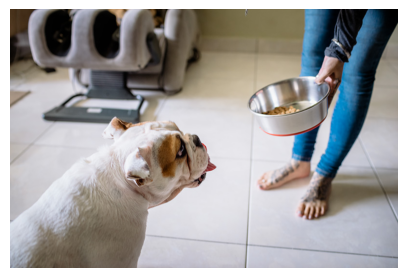

In [28]:
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(image);

Image classification model alone

In [29]:
image_tensor = transform(Image.open(image_path))
output = cv_model(image_tensor.unsqueeze(0))
probabilities = torch.nn.functional.softmax(output[0], dim=0)
values, indices = torch.topk(probabilities, 20)
print('The most likely labels for the given picture are:', '\n')
label_lst = [IMAGENET_1k_LABELS[idx].split(',')[0]
             for value, idx in zip(values, indices)
             if value>=MIN_PROBABILITY]
print(set(label_lst))

The most likely labels for the given picture are: 

{'French_bulldog', 'bull_mastiff', 'mixing_bowl'}


Result obtained with the combination of models:

The given picture probably contains the following items: {'boxer', 'mixing_bowl', 'jean', 'sock', 'ice_lolly'}

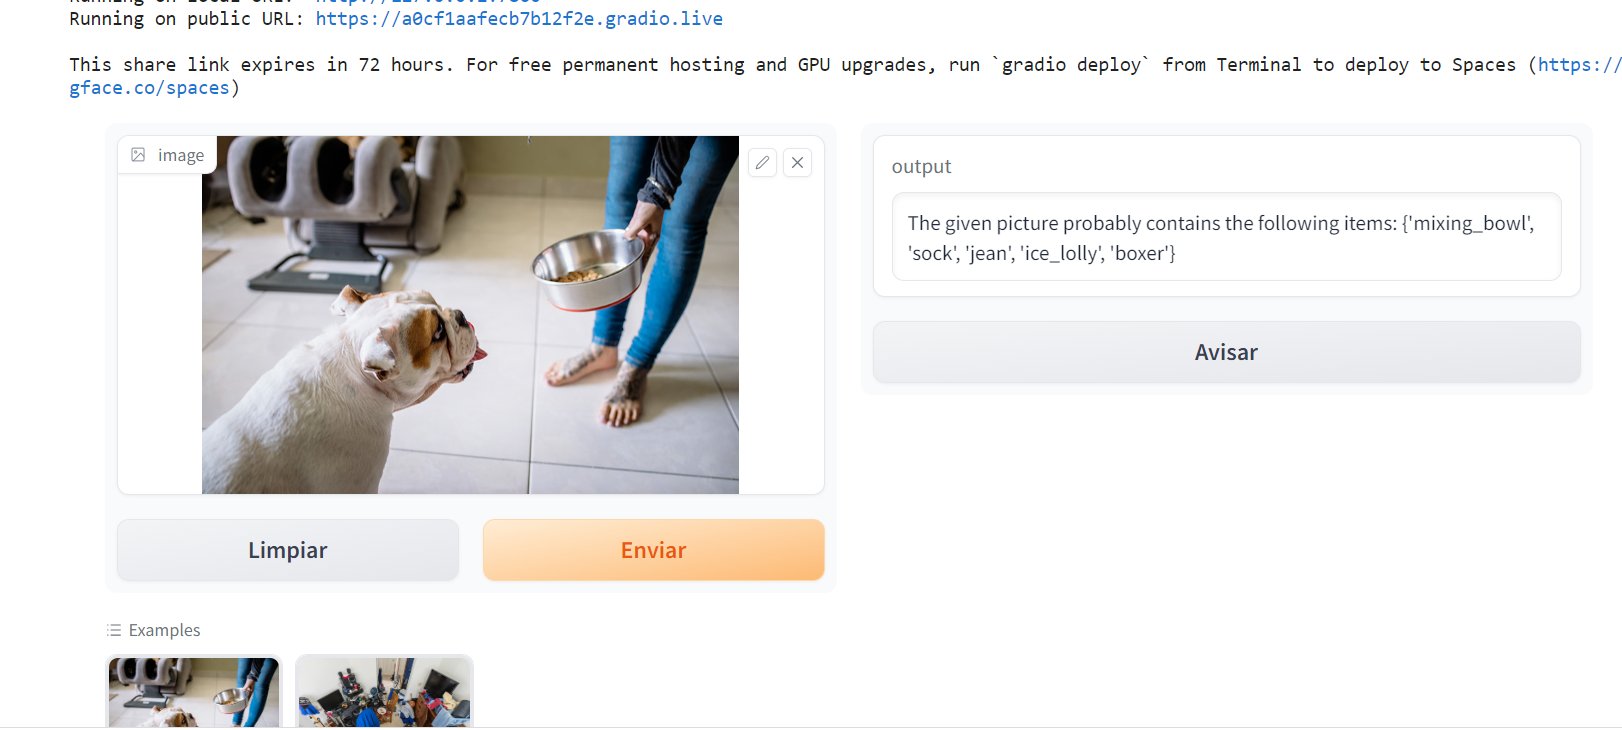

After experimenting with various images, the sole apparent advantage of combining models is

that you receive only one guess per object. However, the overall accuracy of the combined 

model is subpar. This is likely due to the fact that the model has been trained on objects 

devoid of context, against a dark background, and often in unusual sizes. Given these 

circumstances, accurately categorizing most masks/objects becomes challenging even for a human, 

let alone after the image undergoes transformations.

That being said, even if the performance of the combined model were to surpass that of the 

standalone image classification model, it would still be inferior to the capabilities of 

contemporary image-to-prompt models available as of August 2023. Additionally, the ImageNet 

dataset used here only had a thousand possible classes.

## References

- Segment Anything Model (`SAM`) by Meta
    - https://github.com/facebookresearch/segment-anything/blob/main/README.md

    - @article{kirillov2023segany,
          
           title={Segment Anything},
      
           author={Kirillov, Alexander and Mintun, Eric and Ravi, Nikhila and Mao, 
  
                   Hanzi and Rolland, Chloe and Gustafson, Laura and Xiao, Tete and Whitehead,
      
                   Spencer and Berg, Alexander C. and Lo, Wan-Yen and Doll{\'a}r, Piotr and 
      
                   Girshick, Ross},
      
           journal={arXiv:2304.02643},
      
           year={2023}
      }

- Timm Library
    - https://timm.fast.ai/
    - https://huggingface.co/docs/timm/quickstart
    - @misc{rw2019timm,
    
            author = {Ross Wightman},
        
            title = {PyTorch Image Models},
  
            year = {2019},
  
            publisher = {GitHub},
  
            journal = {GitHub repository},
  
            doi = {10.5281/zenodo.4414861},
  
            howpublished = {\url{https://github.com/rwightman/pytorch-image-models}}
       
      }
      
- Convnext Model
    - https://huggingface.co/timm/convnext_small.in12k_ft_in1k_384